In [108]:
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt

from astar_utils import get_neighbor_nodes, is_out_of_bounds, reconstruct_path
from astar_utils import load_board, plot_board, create_video_from_frames
# This is heuristic function h(n). We do not need to define g(n) since it is just counting number of steps.
from astar_utils import manhattan_distance 
enable_animation = True

Here we define direction we can move, starting and goal coordinate, and load the board.

The next section we will run a comparision between 3 strategies and create a animation <br>
the animation may not work if your device do not support the codec. 

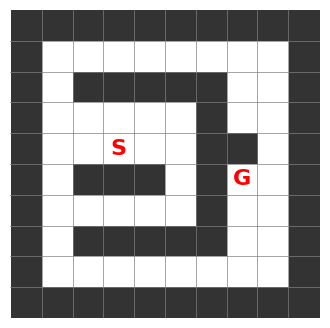

In [109]:
maze_path = 'maze/1.png'
maze_name = maze_path.split('.')[-2].split('/')[-1] # use for naming. don't worry

DIRECTION_MOVES = [(0,1), (0,-1), (-1,0), (1, 0)] # down, up, left, right
board = load_board(maze_path)
XY_WALLS = tuple(zip(*np.where(board==np.inf))) # walls
XY_STARTING = (4, 3)  # starting node
XY_TARGET = (5, 7)  # target node

plot_board(board, None, XY_STARTING, XY_TARGET)

In [110]:
def best_first_search(board, xy_start, xy_target, actual_cost, heuristic_func, enable_animation=False):
    """
    As we mentioned in the paper, Djikstra's algorithm, greedy best-first search, and A* search are equivalent up to the cost function (and stopping condition, but we adapt it here).
     Djikstra's algorithm     : Only actual cost g(n)
     Greedy best-first search : Only heuristic cost h(n)
     A* search                : Sum of actual cost and heuristic cost f(n) = g(n) + h(n)
    """
    frames = []
    
    G = board.copy() # table storing actual cost g(n)
    F = board.copy() # table storing f(n) = g(n) + h(n)
    G[xy_start] = 0 
    F[xy_start] = G[xy_start] + heuristic_func(xy_start, xy_target)
    bestPath = []
    
    frontier = PriorityQueue()
    frontier.put((F[xy_start], xy_start))
    explored_set = set()
    parent_map = {}
    while not frontier.empty():
        cost, current_node = frontier.get() # get the node with lowest f(n) and remove it from the queue.
        explored_set.add(current_node)
        
        
        if enable_animation: # storing frame to create animation.
            frame = plot_board(F, current_node, XY_STARTING, xy_target, frontier, parent_map, None, return_frame=True)
            frames.append(frame)
        
        if current_node == xy_target: # found the goal node.
            bestPath = reconstruct_path(parent_map, XY_STARTING, xy_target)
            
            # Last frame.. even if do not want animation, this will be used in plotting result.
            frame = plot_board(F, current_node, XY_STARTING, xy_target, frontier, parent_map, None, return_frame=True)
            frames.append(frame)
            break

        child_nodes = get_neighbor_nodes(current_node, DIRECTION_MOVES)
        for child in child_nodes:
            if is_out_of_bounds(child, board.shape) or (child in XY_WALLS) or (child in explored_set):
                # Do not explore if the move is invalide.
                continue
            
            # typically, actual_cost is a function or dict accessing the cost,
            # but in our example, actual_cost always equal to 1.
            # we set actual_cost to 0 in greedy best-first search.  
            G[child] = G[current_node] + actual_cost 
            h = heuristic_func(child, xy_target)
            h0 = heuristic_func(current_node, xy_target)
            
            # monotonicity condition: https://stackoverflow.com/questions/4571530/how-is-manhattan-distance-an-admissible-heuristic
            # and https://stackoverflow.com/questions/21174490/monotonicity-and-a-is-it-optimal
            if not h >= h0 - 1: print('warning monotonicity not satified: {h=}, {h0=}, {h0-1=}') 
            
            f = G[child] + h
            if f < F[child]:
                F[child] = f
                frontier.put((f, child))
                parent_map[child] = current_node
    return bestPath, frames

## Figure 3a: Dijkstra's algorithm (using only actual cost).

One detail is that Dijkstra's algorithm does not depend on the goal node. <br>
It find the best path from starting node to any node, but we only interested in goal node.

In [111]:
def no_heuristic(node0, node1): return 0 # no heuristic, hence always return zero.
actual_cost = 1 # Each step cost 1.
bestPath, frames = best_first_search(board, XY_STARTING, XY_TARGET, 
                                     actual_cost, no_heuristic, 
                                     enable_animation
                                     )

In [112]:
if enable_animation:
    from IPython.display import display
    video = create_video_from_frames(frames, f'maze{maze_name}_Dijkstra.mp4', fps=2)
    display(video)
else:
    plt.figure(figsize=(4, 4))
    plt.imshow(frames[-1], )
    plt.tight_layout()
    plt.axis('off')
    plt.show()

## Figure 3b: Greedy best-first search (using only heuristic cost).

Observe that even the cost increase although the algorithm is making progress toward the goal node. <br>

In [113]:
actual_cost = 0 # not using actual cost, hence always zero.
bestPath, frames = best_first_search(board, XY_STARTING, XY_TARGET, 
                                     actual_cost, manhattan_distance, # using manhattan_distance as our heuristc.
                                     enable_animation)

In [114]:
if enable_animation:
    from IPython.display import display
    video = create_video_from_frames(frames, f'maze{maze_name}_Greedy.mp4', fps=2)
    display(video)
else:
    plt.figure(figsize=(4, 4))
    plt.imshow(frames[-1], )
    plt.tight_layout()
    plt.axis('off')
    plt.show()

## Figure 3c: A* (using combined cost).

In [115]:
actual_cost = 1
def heuristic_func(xy0, xy1): 
    return manhattan_distance(xy0, xy1) * 1.1 # It is good to scale up the heuristic as much as possible without breaking the monotinicity condition.

bestPath, frames = best_first_search(board, XY_STARTING, XY_TARGET, 
                                     actual_cost, manhattan_distance, # using manhattan_distance as our heuristc.
                                     enable_animation)

In [116]:
if enable_animation:
    from IPython.display import display
    video = create_video_from_frames(frames, f'maze{maze_name}_Astar.mp4', fps=2)
    display(video)
else:
    plt.figure(figsize=(4, 4))
    plt.imshow(frames[-1], )
    plt.tight_layout()
    plt.axis('off')
    plt.show()